# Практика в библиотеке sklearn, часть 2: Titanik

В этом задании мы применим полученные знания к датасету Titanik для вот этого соренования: https://www.kaggle.com/c/titanic

Данные скачивать с сайта не нужно, они уже лежат в папке рядом с этим ноутбуком.

Почитать о том, что такое каггл: https://www.kaggle.com/getting-started/44916

![alt text](https://imagesvc.timeincapp.com/v3/foundry/image/?q=70&w=1920&url=http%3A%2F%2Fd254andzyoxz3f.cloudfront.net%2F0419160-titanic-real-time-hero.jpg)

## Часть 0. Загрузка датасета

Начем!

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

С помощью библиотеки pandas загрузим данные из файла train_titanik.csv в память и выведем первые 5 записей на экран:

In [12]:
data = pd.read_csv('train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


В датасете представлены данные 891 пассажира Титаника. Данные содержат:

-- id пассажира (PassengerId) <br>
-- класс каюты, в которой ехал пассажир (Pclass, 1, 2 или 3) <br>
-- имя пассажира (Name) <br>
-- пол пассажира (Sex) <br>
-- возраст пассажира (Age) <br>
-- количество родственников пассажира на борту Титаника (SibSp) <br>
-- количество родителей/детей пассажира на борту Титаника (Parch) <br>
-- номер билета пассажира (Ticket) <br>
-- цена билета пассажира (Fare) <br>
-- номер каюты пассажира (Cabin) <br>
-- пункт посадки пассажира на Титаник (Embarked) <br>
-- отметка, выжил человек или не выжил после крушения Титаника (Survived) -- **целевая переменная**

Таким образом, нам нужно построить модель, которая по имеющимся данным о пассажире могла бы предсказывать, выжил человек после крушения Титаника или нет.

Как видно, в данных есть пропуски (NAN в колонке Cabin), некоторые данные категориальные (представлены текстом, а не числами). Чтобы на этих данных можно было обучать модели, нужно заполнить пропуски (избавиться от NaN) и перевести категориальные признаки в числовые. 

## Часть 1. Предобработка признаков

### Удалим ненужные колонки

Давайте подумаем, все ли признаки из таблицы нам важны для решения задачи. Выведем еще раз первые строки таблицы для наглядности:

In [13]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Мы, как люди, знаем, что выживаемость на Титанике не зависела от имени пассажира и номера билета. Поэтому давайте удалим эти колонки. <br>
Также удалим колонку PassengerId, так как она была добавлена в данные для удобства и, очевидно, выживаемость пассажира не зависла от его ID в этом датасете.

In [14]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html
data = data.drop(["PassengerId", "Name", "Ticket"], axis=1)

### Посмотрим на данные

Для начала давайте отделим колонку целевой переменной от датасета и разделим датасет на тренировочный и тестовый. На тренировочном датасете будем обучать KNN, на тестовом -- тестировать.

In [15]:
y = data['Survived']
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html
data = data.drop(["Survived"], axis=1)

Давайте посмотрим, какие в данных есть колонки и какого типа данные в них записаны:

In [16]:
print(data.columns)
print(data.dtypes)

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked'], dtype='object')
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Cabin        object
Embarked     object
dtype: object


И также посмотрим, в каких столбцах данных содержатся NaN:

In [17]:
data.columns[data.isna().any()].tolist()

['Age', 'Cabin', 'Embarked']

Очень часто бывает полезно посмотреть на связь разных признаков между собой на картинке. Это помогает выявить выбросы (элементы, которые "не списываются" в общую картину и, возможно, были добавлены случайно/на них была допущена ошибка при внесении в датасет или они просто уникальны. Такие данные осложняют обучение моделей) и увидеть неожиданные связи между признаками. 

Давайте, например, посмотрим на связь признаков Age и Parch:


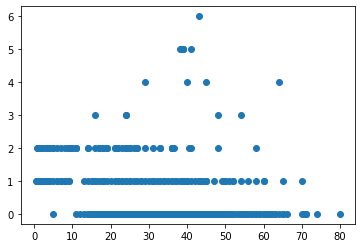

In [18]:
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html
plt.scatter(data["Age"], data["Parch"])

### Заполненим пропуски в данных

Начнем с того, что заполним NaN в колонках, где они есть, какими-нибудь значениями. Для того, чтобы лучше понять, какие значения для пропусков выбрать, полезно посмотреть на данные с точки зрения каких-нибудь статистик (найти среднее по колонке, медиану, самое часто встречающееся значения и т.п.) 

#### 1. Age
Возраст человека может быть любым числом от 0 до $\inf$. Поэтому, кажется, что для колонки Age смотреть на количество строк с каждым отдельным значеним не имеет смысла. Больший смысл имеет найти значения статистик.

In [19]:
data["Age"].mean(), data["Age"].median()

(29.69911764705882, 28.0)

In [20]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html
data["Age"] = data["Age"].fillna(28)

#### 2. Embarked
Колонка Embarked, наоборот, содержит категориальный признак, который имеет мало разных значений в датасете. Поэтому для него как раз имеет смысл найти количества записей с каждым значением в датасете.

In [21]:
data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Заполним отсутствующие значения самым часто встреющимся значением S:

In [22]:
data["Embarked"] = data["Embarked"].fillna('S')

#### Cabin
А вот что делать с колонкой Cabin, сразу непонятно. Она категориальная, и значений в ней много разных. 

Давайте посмотрим, сколько всего неизвестных значений в колонке Cabin:

In [23]:
data['Cabin'].isna().sum(), len(data)

(687, 891)

Как видим, пропусков в этой колонке больше, чем имеющихся значений. Это делает заполнение пропусков очень неточным. Учитывая, что сам признак вряд ли очень полезен, давайте эту колонку тоже удалим.

In [24]:
data = data.drop("Cabin", axis=1)

Отлично, мы разобрались со всемми пропусками, теперь их быть не должно. Давайте убедимся в этом:

In [25]:
# выдает ошибку, если в данных остались пропуски
assert not data.isnull().values.any()

### Перевод категориальных признаков в числа

Модели машинного обучения (за редким исключением) умеют работать только с числовыми признаками. Поэтому все нечисловые признаки придется превратить в числовые. 

Еще раз выведем колонки и их типы:

In [26]:
print(data.columns)
print(data.dtypes)

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object


У нас всего две категориальные колонки (Sex и Embarked). 

In [27]:
data['Sex'].describe()

count      891
unique       2
top       male
freq       577
Name: Sex, dtype: object

#### 1. Sex

В колонке Sex всего два различных значения (male и female). Давайте закодируем эти значения цифрами 0 и 1 и заменим значения в колонке на 0 и 1:

In [28]:
data["Sex"] = data["Sex"].astype('category')
data["Sex"] = data["Sex"].cat.codes

In [29]:
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,22.0,1,0,7.2500,S
1,1,0,38.0,1,0,71.2833,C
2,3,0,26.0,0,0,7.9250,S
3,1,0,35.0,1,0,53.1000,S
4,3,1,35.0,0,0,8.0500,S


#### 2. Embarked

In [29]:
data['Embarked'].describe()

count     891
unique      3
top         S
freq      646
Name: Embarked, dtype: object

В колонке Embarked всего 3 уникальных значения. Мы можем поступить с ними так же, как и с колонкой Sex -- заменить значения на цифры 0, 1 и 2. Но это будет не очень хорошо, потому что мы введем для значений в колонке отношение "больше-меньше", которого на самом деле нет.

Решение такое: давайте создадим три столбца, каждый с названием одного из значений колонки. Каждый столбуц будет содержать числа 0 и 1 -- 1 для тех объектов, значение признака Embarked которых соврадает с названием колонки, и 0 -- если не совпадает.

В Pandas для такого есть специальная функция:

In [30]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
data = pd.get_dummies(data, columns=["Embarked"])
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,3,1,22.0,1,0,7.2500,0,0,1
1,1,0,38.0,1,0,71.2833,1,0,0
2,3,0,26.0,0,0,7.9250,0,0,1
3,1,0,35.0,1,0,53.1000,0,0,1
4,3,1,35.0,0,0,8.0500,0,0,1


Отлично! Мы завершили предобработку признаков датасета. 

Осталось разбить данные на тренировочный и валидационный датасет и можно обучать модель.

### Разбиваем данные на train и val

In [31]:
from sklearn.model_selection import train_test_split
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
train_data, val_data, train_y, val_y = train_test_split(data, y, test_size=0.3)

## Часть 2. Обучение модели.

In [32]:
from sklearn.neighbors import KNeighborsClassifier
# модуль, где лежат различные метрики
from sklearn.metrics import accuracy_score

In [33]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
knn = KNeighborsClassifier(n_neighbors=3)

In [34]:
knn.fit(train_data, train_y)

KNeighborsClassifier(n_neighbors=3)

In [35]:
predicted = knn.predict(val_data)
predicted

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1], dtype=int64)

In [36]:
np.array(val_y)

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0], dtype=int64)

In [37]:
accuracy_score(predicted, val_y)

0.7014925373134329

### Подбор гиперпараметра k

Давайте переберем k от 1 до 20 включительно, обучим для каждого значения k классификатор KNN и посчитаем метрику accuracy_score на валидационной выборке.

In [38]:
val_scores = []
for k in range(1, 21):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(train_data, train_y)
  predicted = knn.predict(val_data)
  acc_score = accuracy_score(predicted, val_y)

  val_scores.append(acc_score)

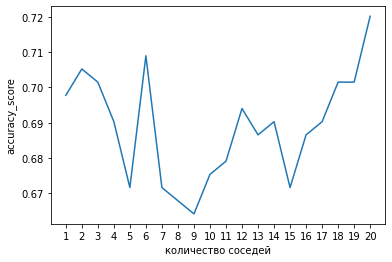

In [39]:
plt.plot(list(range(1, 21)), val_scores)
plt.xticks(list(range(1, 21)))
plt.xlabel("количество соседей")
plt.ylabel("accuracy_score")
plt.show()

## Часть 3. Получение ответов для тестового датасета.

In [0]:
test_data = pd.read_csv("test.csv")
test_data.head()

Предобработаем тестовый датасет **точно так же**, как тренировочный:

In [0]:
# удаляем колонки
test_data = test_data.drop(["PassengerId", "Name", "Ticket"], axis=1)
# заполняем пропуски
test_data["Age"] = test_data["Age"].fillna(28)
test_data["Embarked"] = test_data["Embarked"].fillna('S')
test_data = test_data.drop("Cabin", axis=1)
# переводим категориальные признаки в числовые
test_data["Sex"] = test_data["Sex"].astype('category')
test_data["Sex"] = test_data["Sex"].cat.codes

test_data = pd.get_dummies(test_data, columns=["Embarked"])
test_data.head()

Посмотрим, нет ли в тестовых данных пропусков, которых не было в тренировочном датасете:

In [0]:
test_data.isna().any()

Заполним пропуски в колонке Fare медианой всех значений **тренировочного датасета**:

In [0]:
 test_data["Fare"] = test_data["Fare"].fillna(train_data["Fare"].median())

Обучим KNN на всей тренировочной выборке с оптимальным параметром k (полученным после подбора параметров выше):

In [0]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(data, y)

In [0]:
test_predicted = knn.predict(test_data)

In [0]:
test_predicted

Сохраним ответы на тестовый датасет в нужном виде для отправки в соревнование:

In [0]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html
test_predicted = pd.DataFrame({"Survived": test_predicted})
test_predicted["PassengerId"] = list(range(892, 892+len(test_data)))
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html
test_predicted.to_csv("test_predicted.csv")
test_predicted